# Worksheet 17

Name: Abir Islam
UID: U64547897

### Topics

- Recommender Systems

### Recommender Systems

In the example in class of recommending movies to users we used the movie rating as a measure of similarity between users and movies and thus the predicted rating for a user is a proxy for how highly a movie should be recommended. So the higher the predicted rating for a user, the higher a recommendation it would be.

a) Consider a streaming platform that only has "like" or "dislike" (no 1-5 rating). Describe how you would build a recommender system in this case.

Here, we can use a similar content-based and then collaborative filtering method in order to build our recommender system. We build our content-based feature matrix in the same way as before, by correlating each movie to our set of features such as genre or runtime. Next, we utilize a user-to-feature similarity matrix with the change that the values are in the range [0,1]. Finally, we can use collaborative filtering in order to make the appropriate predictions and to tune our features.

b) Describe 3 challenges of building a recommender system

1. Working with incredibly large datasets with real-time data, it would be difficult to achieve both accuracy and speed with the predictions made by the system, which could lead to errors with the service
2. For users that do not utilize the recommendation system at all, which will be a large portion of the user base, the recommendations provided are entirely predicted based on the recommendations of other users, whose results may be inaccurately imposed upon these users
3. People's taste and interest in different movies is hard to quantify and is dependent upon an impossibly large number of factors to be able to effectively recommend movies with any certainty that the user will pick them.

c) Why is SVD not an option for collaborative filtering?

User-item interaction matrices in collaborative filtering scenarios are often sparse, meaning that most entries are missing or that users have not rated or interacted with most items. SVD tends to struggle with sparsity, as it aims to decompose the entire matrix, including the missing entries, leading to inaccurate results.

d) Use the code below to train a recommender system on a dataset of amazon movies

Kaggle RMSE =  3.3082660808178264


/var/folders/p8/gwtd0ps90hxgzgf5735cmp_c0000gn/T/ipykernel_19416/2717746974.py:64: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rec['prediction'].fillna(1, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


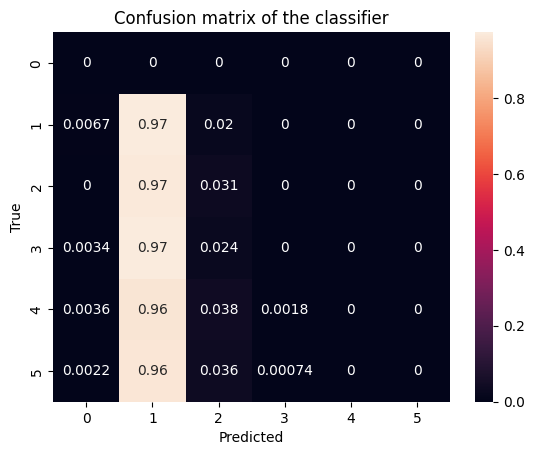

In [32]:
# Note: requires py3.10
import findspark
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

findspark.init()
conf = SparkConf()
conf.set("spark.executor.memory","28g")
conf.set("spark.driver.memory", "28g")
conf.set("spark.driver.cores", "8")
sc = SparkContext.getOrCreate(conf)
spark = SparkSession.builder.getOrCreate()

init_df = pd.read_csv("./train.csv").dropna()
init_df['UserId_fact'] = init_df['UserId'].astype('category').cat.codes
init_df['ProductId_fact'] = init_df['ProductId'].astype('category').cat.codes

# Split training set into training and testing set
X_train_processed, X_test_processed, Y_train, Y_test = train_test_split(
        init_df.drop(['Score'], axis=1),
        init_df['Score'],
        test_size=1/4.0,
        random_state=0
    )

X_train_processed['Score'] = Y_train
df = spark.createDataFrame(X_train_processed[['UserId_fact', 'ProductId_fact', 'Score']])
als = ALS(
    userCol="UserId_fact",
    itemCol="ProductId_fact",
    ratingCol="Score",
    coldStartStrategy="drop",
    nonnegative=True,
    rank=100
)
# param_grid = ParamGridBuilder().addGrid(
        # als.rank, [10, 50]).addGrid(
        # als.regParam, [.1]).addGrid(
        # # als.maxIter, [10]).build()
# evaluator = RegressionEvaluator(
        # metricName="rmse",
        # labelCol="Score", 
        # # predictionCol="prediction")
# cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3, parallelism = 6)
# cv_fit = cv.fit(df)
# rec_sys = cv_fit.bestModel

rec_sys = als.fit(df)

X_test2 = spark.createDataFrame(X_test_processed[['UserId_fact', 'ProductId_fact']])
preds = rec_sys.transform(X_test2).toPandas()

rec = pd.merge(X_test_processed, preds, on=['UserId_fact', 'ProductId_fact'], how='left')

rec['prediction'].fillna(1, inplace=True)
X_test_processed['Score'] = rec['prediction'].values

print("Kaggle RMSE = ", mean_squared_error(X_test_processed['Score'], Y_test, squared=False))

cm = confusion_matrix(Y_test.round(), X_test_processed['Score'].round(), normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()